# Data preparation: exploration and normalization

- The start point was to observe and analyze the tables in the dataset to understand how the data is distributed (Pandas libraries for Python is used to handle the tables as dataframes).
- The common functions of Pandas DataFrame to use for an overview of the table are the following:

  ``` python
  dataframe.info()
  dataframe.head()
  dataframe.describe()
  ```

- After reviewing the contents of the various tables in the MIMIC database, only some tables were selected and loaded into DataFrames using Pandas because it was assumed that it wasn't necessary or useful for prediction to include all tables. 

So the table selected that compose the baseline dataset are the following:
- **ADMISSIONS.csv** that defines a patient’s hospital admission,   
- **PATIENTS.csv** that defines a single patient, 
- **DIAGNOSES_ICD.csv** that contains ICD diagnoses for patients, most notably ICD-9 diagnoses (after this matter will be better explained),

Other tables will be considered, if necessary for the specific task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### ADMISSIONS table

In [2]:
mimic4_path = './data/mimic-iv-clinical-database-demo-2.2/'

# read admissions table
def read_admissions_table(mimic4_path):
    admits = pd.read_csv(mimic4_path + 'hosp/admissions.csv')
    # Pre-emptively don't include some columns that I don't need
    admits = admits[['subject_id','hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'insurance']]
    # Converts dates to a proper format
    admits.admittime = pd.to_datetime(admits.admittime)
    admits.dischtime = pd.to_datetime(admits.dischtime)
    admits.deathtime = pd.to_datetime(admits.deathtime)
    return admits

admits = read_admissions_table(mimic4_path)
admits.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaT,URGENT,Medicaid
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaT,URGENT,Medicaid
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaT,URGENT,Medicare
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,Medicaid
4,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,NaT,URGENT,Other


In [3]:
admits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subject_id      275 non-null    int64         
 1   hadm_id         275 non-null    int64         
 2   admittime       275 non-null    datetime64[ns]
 3   dischtime       275 non-null    datetime64[ns]
 4   deathtime       15 non-null     datetime64[ns]
 5   admission_type  275 non-null    object        
 6   insurance       275 non-null    object        
dtypes: datetime64[ns](3), int64(2), object(2)
memory usage: 15.2+ KB


When DEATHTIME in ADMISSIONS is not null then the patient associated died at the hospital, so we mark this distinction with a boolean variable.

In [4]:
admits['died_at_the_hospital'] = admits['deathtime'].notnull().map({True:1, False:0})

In [5]:
# ADMISSION_TYPE
admits['admission_type'].value_counts()

admission_type
EW EMER.                       104
OBSERVATION ADMIT               45
URGENT                          38
EU OBSERVATION                  30
SURGICAL SAME DAY ADMISSION     18
DIRECT EMER.                    15
ELECTIVE                        13
DIRECT OBSERVATION               7
AMBULATORY OBSERVATION           5
Name: count, dtype: int64

# Compresse into EMERGENCY
The category URGENT is a lot similar semantically to EMERGENCY or DIRECT EMERGENCY, so could combine these categories in EMERGENCY. We could do the same process also for all those categories that are related to OBSERVATION.

In [6]:
admits.loc[:, 'admission_type'] = admits['admission_type'].replace('EW EMER.', 'EMERGENCY')
admits.loc[:, 'admission_type'] = admits['admission_type'].replace('DIRECT EMER.', 'EMERGENCY')
admits.loc[:, 'admission_type'] = admits['admission_type'].replace('URGENT', 'EMERGENCY')

admits['admission_type'].value_counts()

admission_type
EMERGENCY                      157
OBSERVATION ADMIT               45
EU OBSERVATION                  30
SURGICAL SAME DAY ADMISSION     18
ELECTIVE                        13
DIRECT OBSERVATION               7
AMBULATORY OBSERVATION           5
Name: count, dtype: int64

In [7]:
# read patients table
def read_patients_table(mimic4_path):
    pats = pd.read_csv(mimic4_path + 'hosp/patients.csv')
    # Pre-emptively don't include some columns that I don't need
    pats = pats[['subject_id', 'gender', 'anchor_age', 'dod']]
    pats.dod = pd.to_datetime(pats.dod)
    return pats

patients = read_patients_table(mimic4_path)
patients.head()

,subject_id,gender,anchor_age,dod
0,10014729,F,21,NaT
1,10003400,F,72,2137-09-02
2,10002428,F,80,NaT
3,10032725,F,38,2143-03-30
4,10027445,F,48,2146-02-09


As we can see from age distribution, patients in their childhood are not present, this reflects the fact that MIMIC-IV as MIMIC-III does not contain data from pediatric patients.

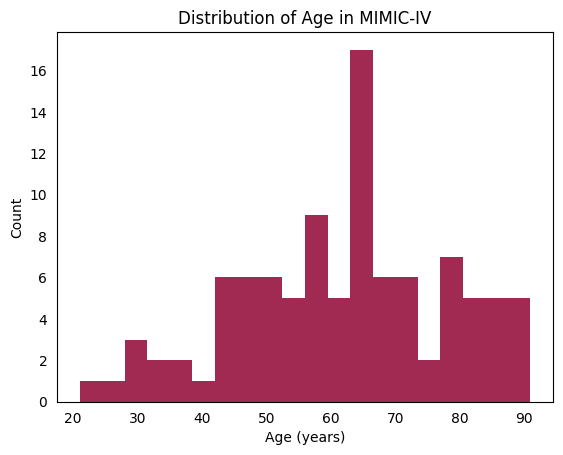

In [8]:
#let's see the distribution of age
plt.hist(patients['anchor_age'], bins=20, color='#a12a52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

In [9]:
patients['gender'].value_counts()

gender
M    57
F    43
Name: count, dtype: int64

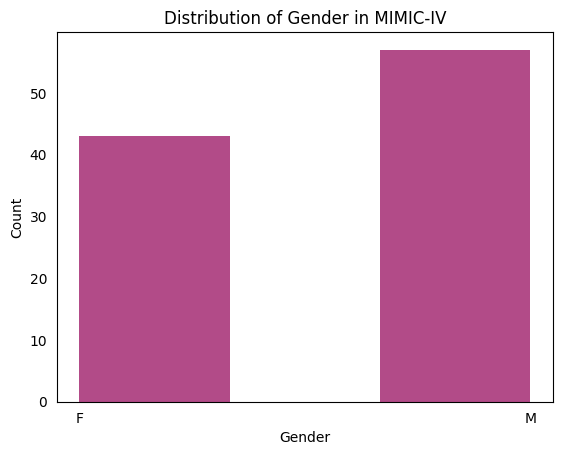

In [10]:
# distribution of gender
plt.hist(patients['gender'], bins=3, color='#b24b88')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Distribution of Gender in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

We can see how the gender is almost equally balanced.

Now we merge patients and admissions tables on 'subject_id' link.

In [11]:
# merge the PATIENTS table with ADMISSIONS table
admits_patients = pd.merge(admits, patients, how='inner', on='subject_id')
admits_patients.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,died_at_the_hospital,gender,anchor_age,dod
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaT,EMERGENCY,Medicaid,0,M,47,NaT
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaT,EMERGENCY,Medicaid,0,M,58,NaT
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaT,EMERGENCY,Medicare,0,M,79,2134-10-28
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,EMERGENCY,Medicaid,1,M,52,2111-11-15
4,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,NaT,EMERGENCY,Other,0,F,82,NaT


# read diagnoses_icd table

In [12]:

def read_diagnoses_icd_table(mimic4_path):
    diag_icds = pd.read_csv(mimic4_path + 'hosp/diagnoses_icd.csv')
    return diag_icds

diag_icds = read_diagnoses_icd_table(mimic4_path)
diag_icds.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10035185,22580999,3,4139,9
1,10035185,22580999,10,V707,9
2,10035185,22580999,1,41401,9
3,10035185,22580999,9,3899,9
4,10035185,22580999,11,V8532,9


In [13]:
diag_icds.count()

subject_id     4506
hadm_id        4506
seq_num        4506
icd_code       4506
icd_version    4506
dtype: int64

In [14]:
diag_icds.icd_version.value_counts()

icd_version
10    2313
9     2193
Name: count, dtype: int64

We can notice that there are two version of icd_code: version 9 and 10. In general, ICD-10 codes are more detailed, but they could be mapped and converted to ICD-9 because they expresse the same concept.

Since we are dealing with a dataframe with a lot of entries and in any case it should later be reduced in size for a faster test, for simplicity we consider only the diagnoses with ICD9 codes.

In [15]:
diag_icds = diag_icds[diag_icds['icd_version'] == 9]
diag_icds.icd_version.value_counts()

icd_version
9    2193
Name: count, dtype: int64

International Classification of Diseases, Clinical Modification (ICD-CM in version 9 and 10) is an adaption created by the U.S. National Center for Health Statistics (NCHS) and used in assigning diagnostic and procedure codes associated with inpatient, outpatient, and physician office utilization in the United States.

In [16]:
print('There are {} unique ICD9 codes in this dataset.'.format(diag_icds['icd_code'].value_counts().count()))

There are 740 unique ICD9 codes in this dataset.


In [17]:
# Filter out E and V codes from ICD9 codes since processing will be done on the numeric first 3 values
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings

diag_icds['recode'] = diag_icds['icd_code']
diag_icds.loc[:, 'recode'] = diag_icds['recode'].fillna(value='999')

diag_icds['recode'] = diag_icds['recode'][~diag_icds['recode'].str.contains("[a-zA-Z]").fillna(False)]
diag_icds['recode'].fillna(value='999', inplace=True)

# Take in consideration just the first 3 integers of the ICD9 code
diag_icds['recode'] = diag_icds['recode'].str.slice(start=0, stop=3, step=1)
diag_icds['recode'] = diag_icds['recode'].astype(int)
diag_icds.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,recode
0,10035185,22580999,3,4139,9,413
1,10035185,22580999,10,V707,9,999
2,10035185,22580999,1,41401,9,414
3,10035185,22580999,9,3899,9,389
4,10035185,22580999,11,V8532,9,999


In [18]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diag_icds['recode'] = np.where(diag_icds['recode'].between(cat_range[0],cat_range[1]), num, diag_icds['recode'])
    
# Convert integer to category name using diag_dict
diag_icds['super_category'] = diag_icds['recode'].replace(diag_dict)
diag_icds.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,super_category
0,10035185,22580999,3,4139,9,6,circulatory
1,10035185,22580999,10,V707,9,16,injury
2,10035185,22580999,1,41401,9,6,circulatory
3,10035185,22580999,9,3899,9,5,nervous
4,10035185,22580999,11,V8532,9,16,injury


In [19]:
# Create list of diagnoses for each admission
hadm_list = diag_icds.groupby('hadm_id')['super_category'].apply(list).reset_index()
hadm_list.head()

,hadm_id,super_category
0,20044587,"[injury, injury, circulatory, circulatory, end..."
1,20192635,"[endocrine, digestive, injury, misc, genitouri..."
2,20214994,"[injury, circulatory, injury, mental, injury, ..."
3,20285402,"[infectious, infectious, injury, infectious, e..."
4,20291550,"[injury, injury, genitourinary, respiratory, e..."


In [20]:
stacked = hadm_list['super_category'].apply(pd.Series).stack()
hadm_item = pd.get_dummies(stacked).groupby(level=0).sum()
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin
0,0,3,0,0,1,0,0,3,0,0,0,1,0,0,0,0
1,0,1,1,1,3,3,0,4,2,2,0,0,0,1,0,0
2,2,4,0,3,2,2,1,17,1,0,1,2,0,0,1,0
3,1,2,0,1,3,0,3,2,1,1,0,0,0,0,0,0
4,0,0,0,0,1,1,1,6,1,0,0,0,0,0,1,0


# Join back with HADM_ID

In [21]:
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")

# Merge with main dataframe

In [22]:
admits_patients_diag = pd.merge(admits_patients, hadm_item, how='inner', on='hadm_id')
admits_patients_diag.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,died_at_the_hospital,gender,anchor_age,...,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaT,EMERGENCY,Medicaid,0,M,47,...,1,2,1,3,0,0,1,0,2,0
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaT,EMERGENCY,Medicaid,0,M,58,...,0,1,0,0,0,0,1,0,0,0
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaT,EMERGENCY,Medicare,0,M,79,...,0,6,1,0,0,0,0,0,0,0
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,EMERGENCY,Medicaid,1,M,52,...,0,0,1,1,0,0,0,0,0,0
4,10005817,20626031,2132-12-12 01:43:00,2132-12-20 15:04:00,NaT,EMERGENCY,Medicare,0,M,66,...,1,8,2,1,1,0,0,0,1,0


# Save this version of the dataframe to a csv. It will be used as baseline for our prediction tasks

In [23]:
admits_patients_diag.to_csv('admits_patients_diag.csv')